### RF and LGBM Classifers

We will take the preprocessed data and iterate through multiple RF and LGBM classifiers to priduce the optimal model.

### Code

Let's build an RF classifier for this dataset. First, we need to delete the entry with the `gender` field set to Other.

In [219]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer, f1_score, recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

In [100]:
# Load in pre-processed data
df = pd.read_csv('preprocessed_stroke_data.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5110 non-null   int64  
 1   gender                          5109 non-null   float64
 2   age                             5110 non-null   float64
 3   hypertension                    5110 non-null   int64  
 4   heart_disease                   5110 non-null   int64  
 5   ever_married                    5110 non-null   int64  
 6   avg_glucose_level               5110 non-null   float64
 7   bmi                             5110 non-null   float64
 8   stroke                          5110 non-null   int64  
 9   work_type_Govt_job              5110 non-null   bool   
 10  work_type_Never_worked          5110 non-null   bool   
 11  work_type_Private               5110 non-null   bool   
 12  work_type_Self-employed         51

We can see that `gender` is missing one row of data. Just going to delete this entire entry and the `id` column because this variable should not have any predictive power.

In [103]:
# Delete entry of data that is missing gender value
df = df.drop(columns=['id'])
df = df.dropna(subset=['gender'])
print('Number of missing values in gender feature:', df['gender'].isna().sum())

Number of missing values in gender feature: 0


In [105]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5109 non-null   float64
 1   age                             5109 non-null   float64
 2   hypertension                    5109 non-null   int64  
 3   heart_disease                   5109 non-null   int64  
 4   ever_married                    5109 non-null   int64  
 5   avg_glucose_level               5109 non-null   float64
 6   bmi                             5109 non-null   float64
 7   stroke                          5109 non-null   int64  
 8   work_type_Govt_job              5109 non-null   bool   
 9   work_type_Never_worked          5109 non-null   bool   
 10  work_type_Private               5109 non-null   bool   
 11  work_type_Self-employed         5109 non-null   bool   
 12  work_type_children              5109 no

Looks like our change successfully went through. Going to save off this modified dataset to a new CSV file.

In [108]:
# Export dataframe to CSV file
df.to_csv('preprocessed_stroke_data_v2.csv', index=False)

Now, let's get to building our RF classifier on this latest version of the stroke dataset. The target variable in this scenario is `stroke`.

In [111]:
# Set target variable and features
X = df.drop(columns=['stroke'])
y = df['stroke']

In [113]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
# Train RF classifier and make predictions
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [116]:
# Check out performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9383561643835616

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



Our RF model achieved an accuracy score of 93.84%, which is very solid, but may be a little misleading. The precision, recall, and f1-score are all 0 for predicting Class 1 (having a stroke). This suggests the model is achieving a high accuracy score just by predicting everything to be Class 0. Of the 5109 entries in this dataset, only 250 of them represent patients who suffered from a stroke. This means only 4.89% of the data consists of Class 1 entries, so blindly predicting Class 0 for everything could lead to a high accuracy rate anyways. Let's redo this model, but taking into account this vast class imbalance in our data.

In [120]:
# Another RF classifier but give more importance to minority class
rf_2 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_2.fit(X_train, y_train)
y_pred_2 = rf_2.predict(X_test)

In [121]:
# Check out performance for second iteration of RF classifier
print("Accuracy:", accuracy_score(y_test, y_pred_2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_2))

Accuracy: 0.9393346379647749

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



Unfortunately, basically the same result as our first model. Gonna try to oversample the minority class using SMOTE in the train/test sets. 

In [125]:
# Another RF classifier but train/test sets oversample the minority class
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
rf_3 = RandomForestClassifier(random_state=42)
rf_3.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [127]:
# Check out predictions and performance
y_pred_3 = rf_3.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_3))

Accuracy: 0.9315068493150684

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       960
           1       0.10      0.02      0.03        62

    accuracy                           0.93      1022
   macro avg       0.52      0.50      0.50      1022
weighted avg       0.89      0.93      0.91      1022



After using SMOTE to change the sampling method, we see a small decrease in overall accuracy. The model is improving its ability to successfully predict Class 1 entries, but still not great performance. For Class 1, the precision metric is 0.10, which means only 10% of the model's predicted strokes were actually strokes. The recall score of 0.02 means the classifier only found 3% of all the real stroke cases. Not sure if this is even better than just randomly guessing. Let's see what happens if we combine SMOTE sampling and class balancing.

In [130]:
# RF classifier using SMOTE and class balancing
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
rf_4 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_4.fit(X_train_resampled, y_train_resampled)
y_pred_4 = rf_4.predict(X_test)

In [131]:
# Check out predictions and performance
print("Accuracy:", accuracy_score(y_test, y_pred_4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_4))

Accuracy: 0.9315068493150684

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       960
           1       0.10      0.02      0.03        62

    accuracy                           0.93      1022
   macro avg       0.52      0.50      0.50      1022
weighted avg       0.89      0.93      0.91      1022



Model still not doing great in accurately predicting stroke occurrences. Let's check out the feature importances to see if Class 1 is separable at all. If not, then it will be hard for any model to succeed in correctly identifying strokes. 

In [135]:
# Investigate feature importances for this latest model (rf_4)
importances = rf_4.feature_importances_
feature_names = X.columns
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
top_features = feat_importances.head(5)['Feature'].tolist()
print("Top Features:", top_features)

Top Features: ['age', 'avg_glucose_level', 'gender', 'bmi', 'work_type_Private']


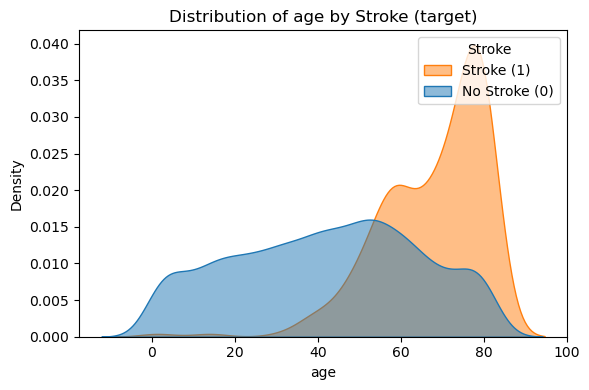

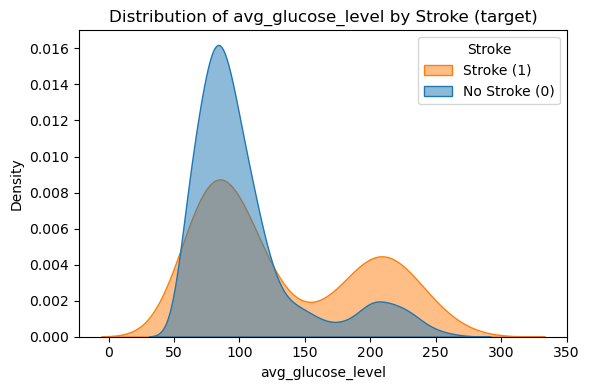

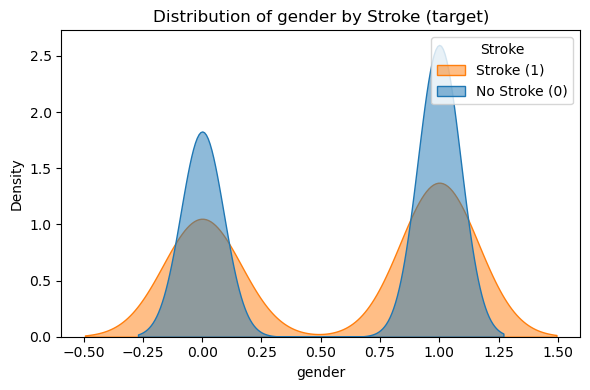

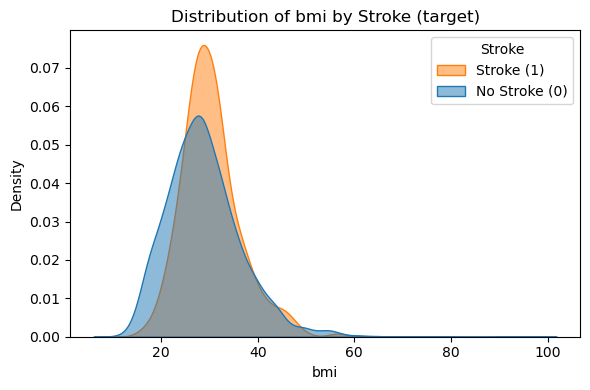

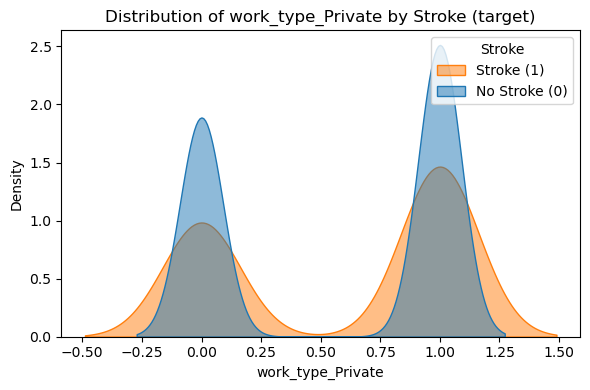

In [141]:
# See how top features differ from stroke and non-stroke cases
for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=feature, hue='stroke', common_norm=False, fill=True, alpha=0.5)
    plt.title(f"Distribution of {feature} by Stroke (target)")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend(title="Stroke", labels=["Stroke (1)", "No Stroke (0)"])
    plt.tight_layout()
    plt.show()

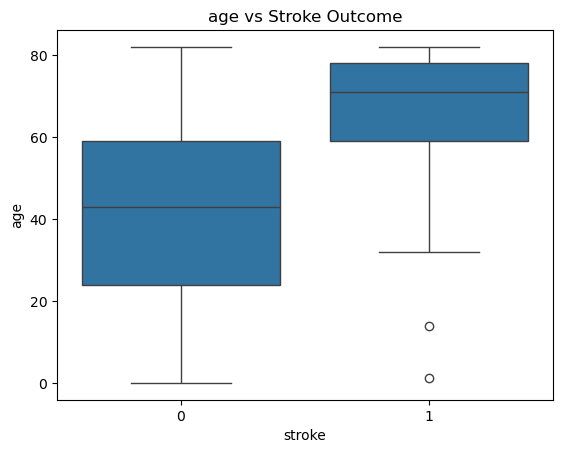

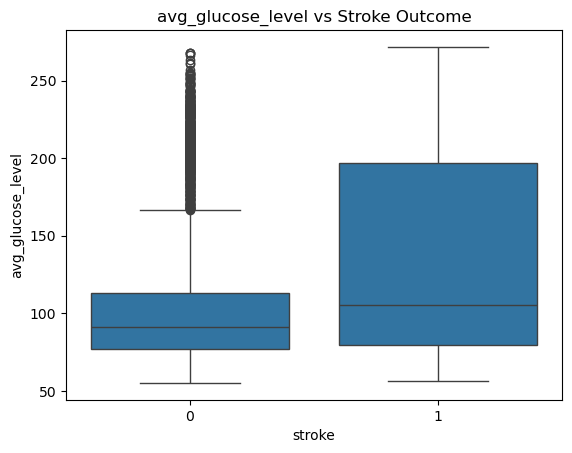

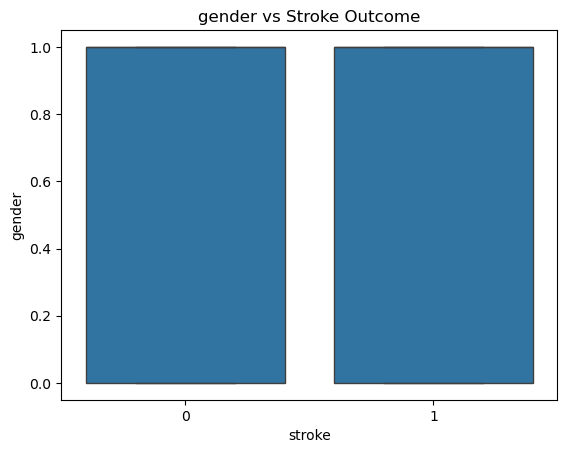

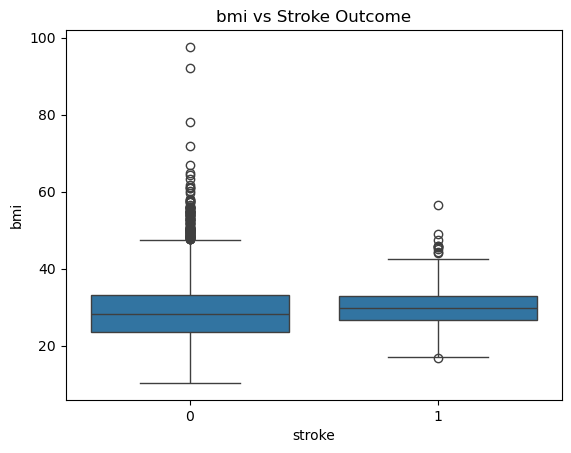

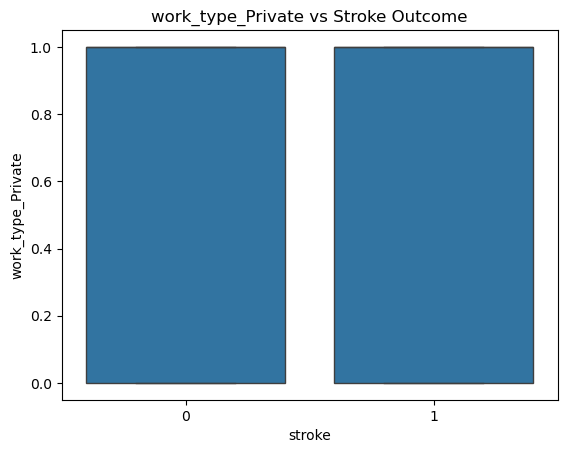

In [139]:
# Use boxplot to view separability between classes
for feature in top_features:
    sns.boxplot(x='stroke', y=feature, data=df)
    plt.title(f"{feature} vs Stroke Outcome")
    plt.show()

Based on these results, there does appear to be separation between Class 0 and Class 1 for some of these top features, especially `age` and `avg_glucose_level`. Let's check out all of the feature importances in the model to see if there are any less influential ones that can be dropped.

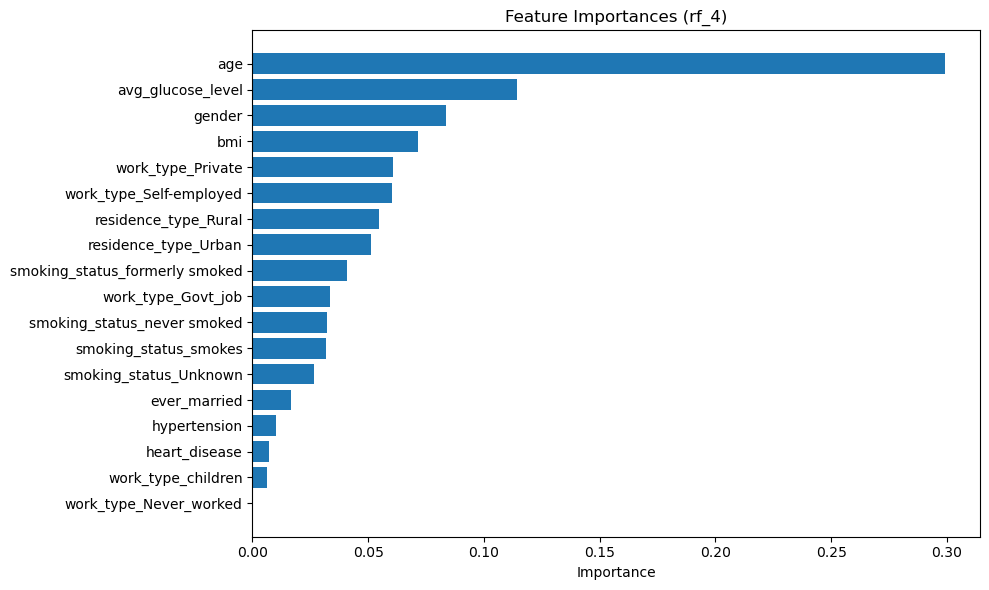

In [146]:
# Visualize all feature importances
plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importances (rf_4)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

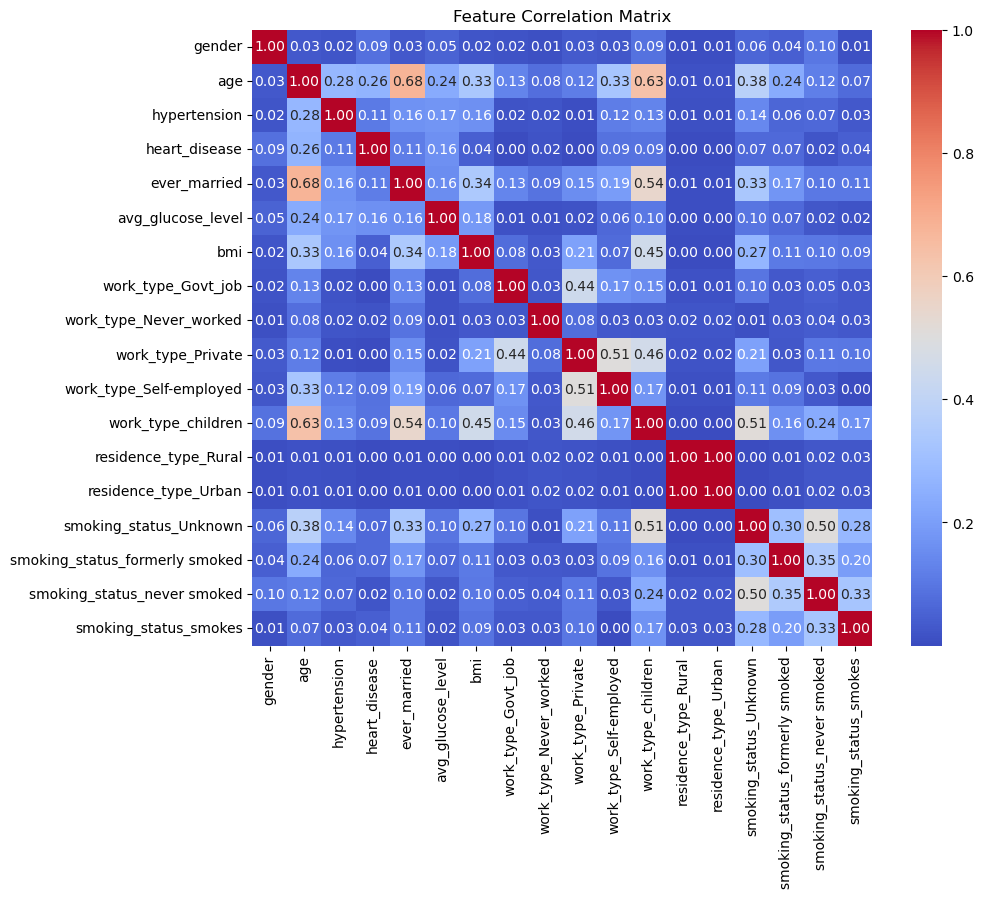

In [156]:
# Check correlation of features and redundancy
corr_matrix = X.corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

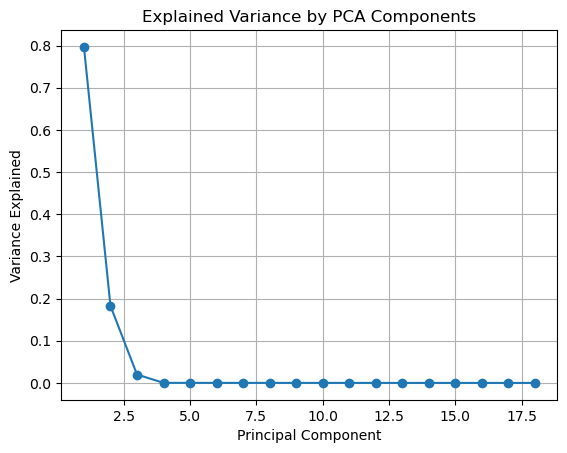

In [160]:
# Use PCA for dimentionality reduction
pca = PCA()
X_pca = pca.fit_transform(X)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

It looks like there are some features with little importance that can be dropped, while still being able to explain variance in the dataset:
- `work_type_Never_worked`
- `work_type_children`
- `heart_disease`
- `hypertension`

Let's drop these four features and try again.

In [165]:
# Drop features
features_to_drop = ['work_type_Never_worked', 'work_type_children', 'heart_disease', 'hypertension']  # Replace with your actual column names
df_reduced = df.drop(columns=features_to_drop)

In [193]:
# Split data into train/test sets
X = df_reduced.drop(columns=['stroke'])
y = df_reduced['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
# Use SMOTE on training data and build another RF classifier
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
rf_new = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_new.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [199]:
# Check out performance
y_pred = rf_new.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9344422700587084

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.27      0.05      0.08        62

    accuracy                           0.93      1022
   macro avg       0.61      0.52      0.52      1022
weighted avg       0.90      0.93      0.91      1022



Still not great at correctly predicting occurrence of strokes. Let's try a LightGBM model that works well with class imbalances.

In [215]:
# LightGBM model
X = df_reduced.drop(columns=['stroke'])
y = df_reduced['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 4087, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [221]:
# Check out model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       972
           1       0.19      0.42      0.26        50

    accuracy                           0.88      1022
   macro avg       0.58      0.66      0.60      1022
weighted avg       0.93      0.88      0.90      1022

Confusion Matrix:
 [[882  90]
 [ 29  21]]


Good to see this LightGBM model performing better than our Random Forest classifier. However, the precision and recall scores are still not pretty. Let's try some hyperparameter tuning to see if we can improve.

In [226]:
# Optimize hyperparameters
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20]
}
grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 4087, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [228]:
# Check out model performance
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89       972
           1       0.15      0.64      0.24        50

    accuracy                           0.81      1022
   macro avg       0.56      0.73      0.57      1022
weighted avg       0.94      0.81      0.86      1022

Confusion Matrix:
 [[792 180]
 [ 18  32]]


This is the best recall score we have gotten so far, which means this model is the best at correctly predicting the occurrence of strokes. Of all the predictions the model labelled as stroke, only 15% were actually stroke cases. Also, our model caught 64% of all the actual stroke cases. Let's check out this model's weighing of each feature.

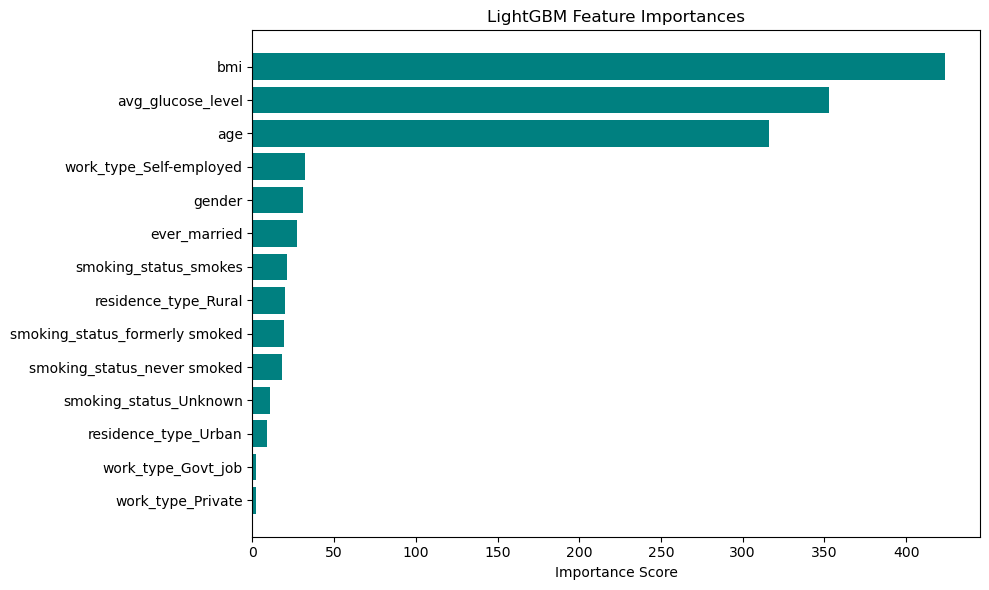

In [231]:
# Plot LightGBM feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

It seems like `work_type_Govt_job` and `work_type_Private` are not very important. So, let's drop those and rebuild the model. 

In [236]:
# Drop features, re-split data, and retrain with grid search
low_importance_features = ['work_type_Private', 'work_type_Govt_job']
reduced_df_v2 = df_reduced.drop(columns=low_importance_features)
X = reduced_df_v2.drop(columns=['stroke'])
y = reduced_df_v2['stroke']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
lgbm_retrained = LGBMClassifier(
    **grid.best_params_,  
    class_weight='balanced',
    random_state=42
)
lgbm_retrained.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 199, number of negative: 3888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 4087, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMClassifier(class_weight='balanced', max_depth=3, n_estimators=200,
               num_leaves=15, random_state=42)

In [238]:
# Evaluate performance
y_pred = lgbm_retrained.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88       972
           1       0.14      0.66      0.24        50

    accuracy                           0.79      1022
   macro avg       0.56      0.73      0.56      1022
weighted avg       0.94      0.79      0.85      1022

Confusion Matrix:
 [[777 195]
 [ 17  33]]


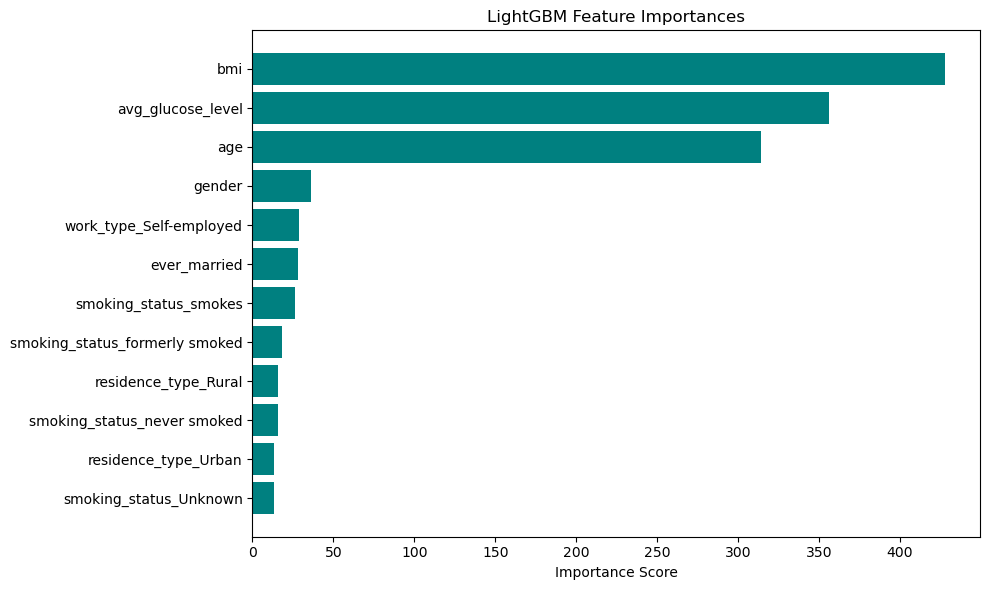

In [242]:
# Plot LightGBM feature importances
importances = lgbm_retrained.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Overall, a LightGBM model is definitely better suited for this dataset over a RF classifier. Depending on if we value precision or recall more, we can modify how the model is built. However, the class imbalance in this dataset makes it a little challenging.